# Zadanie 3

Sources

Network architecture

https://cs231n.github.io/convolutional-networks/

Tips for data tranformations

https://cseweb.ucsd.edu/classes/wi08/cse253/Handouts/lecun-98b.pdf

Mean and std of CIFAR-10

https://stackoverflow.com/questions/66678052/how-to-calculate-the-mean-and-the-std-of-cifar10-data

Libraries

In [ ]:
import os, random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models
from torch.utils.data import DataLoader
from torchvision import transforms
import torch_directml
from torchmetrics.classification import Accuracy
from torchvision.datasets import CIFAR10
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


Setting const values

In [ ]:
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2023, 0.1994, 0.2010)
N_CLASSES = 10
ROOT = "./data"

def set_seed(seed=123):
    """Sets constant seed across the program for reproducibility.
    
    Ensures deterministic behavior
    by setting seeds in the 
    random, 
    numpy,
    and torch libraries.
    
    Args:
        seed (int): The seed value for reproducibility. Defaults to 123.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(123)

device = torch_directml.device()

In [ ]:



train_transforms = transforms.Compose([

    #Random cropping makes the model more robust to small shifts.
    transforms.RandomCrop(32, padding=4),
    
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),

    # Data normalization helps stabilize training and allows for a larger learning rate.
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])



Preparing dataloaders

In [ ]:

dataset_train = CIFAR10(
    root=ROOT,
    train=True,
    download=True,
    transform=train_transforms
)

dataset_test = CIFAR10(
    root=ROOT,
    train=False,
    download=True,
    transform=test_transforms   
)

dataloader_train = DataLoader(
    dataset_train,
    batch_size=128,
    shuffle=True,
    num_workers=8,
    persistent_workers=True,
    prefetch_factor=2
)

dataloader_test = DataLoader(
    dataset_test,
    batch_size=128,
    shuffle=False,
    num_workers=8,
    persistent_workers=True,
    prefetch_factor=2
)

Files already downloaded and verified


c:\Users\egrac\Desktop\Cloud-Image-Classification-PyTorch-\.venv\Lib\site-packages\torchvision\datasets\cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


Files already downloaded and verified


In [ ]:


class Net1(nn.Module):
    """3-layer Convolutional Neural Network for CIFAR-10 image classification.
    
    A CNN architecture with three convolutional blocks, max pooling layers,
    and adaptive average pooling for feature extraction. Uses ReLU activation
    and includes a linear classifier for final predictions.
    
    Architecture:
        Block 1:
            - Conv2d(3 -> 32) + ReLU
            - Conv2d(32 -> 32) + ReLU + MaxPool
        Block 2:
            - Conv2d(32 -> 64) + ReLU
            - Conv2d(64 -> 64) + ReLU + MaxPool
        Block 3:
            - Conv2d(64 -> 128) + ReLU
            - AdaptiveAvgPool2d + Flatten
        Classifier:
            - Linear(128 -> num_classes)
    
    Attributes:
        features_extractor (nn.Sequential): Feature extraction layers.
        classifier (nn.Linear): Final classification layer.
    
    Args:
        num_classes (int): Number of output classes. Default is 10 for CIFAR-10.
    
    Example:
        >>> model = Net1(num_classes=10)
        >>> x = torch.randn(32, 3, 32, 32)  # Batch of 32 CIFAR-10 images
        >>> output = model(x)
        >>> output.shape
        torch.Size([32, 10])
    """
    def __init__(self, num_classes):
        super().__init__()
        self.features_extractor = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.AdaptiveAvgPool2d((1,1)),

            nn.Flatten(),

            
        )
    
        self.classifier = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.features_extractor(x)
        x = self.classifier(x)
        return x
    


In [ ]:
class Net2(nn.Module):
    """3-layer Convolutional Neural Network with Batch Normalization for CIFAR-10.
    
    A CNN architecture with three convolutional blocks,
    batch normalization layers,
    max pooling, 
    and adaptive average pooling for feature extraction. 
    Batch normalization
    stabilizes training and improves model convergence.
    
    Architecture:
        Block 1:
            - Conv2d(3 -> 32, 3x3) + BatchNorm + ReLU
            - Conv2d(32 -> 32, 3x3) + BatchNorm + ReLU
            - MaxPool2d(2x2) -> output: 32x16x16
        
        Block 2:
            - Conv2d(32 -> 64, 3x3) + BatchNorm + ReLU
            - Conv2d(64 -> 64, 3x3) + BatchNorm + ReLU
            - MaxPool2d(2x2) -> output: 64x8x8
        
        Block 3:
            - Conv2d(64 -> 128, 3x3) + BatchNorm + ReLU
            - AdaptiveAvgPool2d(1x1) 
            - Flatten -> output: 128
        
        Classifier:
            - Linear(128 -> num_classes)
    
    Attributes:
        features_extractor (nn.Sequential): Feature extraction layers with batch normalization.
        classifier (nn.Linear): Final classification layer.
    
    Args:
        num_classes (int): Number of output classes. Default is 10 for CIFAR-10.
    
    Example:
        >>> model = Net2(num_classes=10)
        >>> x = torch.randn(32, 3, 32, 32)  # Batch of 32 CIFAR-10 images
        >>> output = model(x)  # Shape: [32, 10]
        >>> output.shape
        torch.Size([32, 10])
    """
    def __init__(self, num_classes):
        super().__init__()
        self.features_extractor = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features_extractor(x)
        return self.classifier(x)


In [ ]:
class Net3(nn.Module):
    """3-layer Convolutional Neural Network with Dropout Regularization for CIFAR-10.
    
    A CNN architecture with three convolutional blocks, max pooling layers,
    and dropout regularization to prevent overfitting. Uses ReLU activation
    and adaptive average pooling for feature extraction.
    
    Architecture:
        Block 1:
            - Conv2d(3 -> 32, 3x3) + ReLU
            - Conv2d(32 -> 32, 3x3) + ReLU
            - MaxPool2d(2x2) -> output: 32x16x16
        
        Block 2:
            - Conv2d(32 -> 64, 3x3) + ReLU
            - Conv2d(64 -> 64, 3x3) + ReLU
            - MaxPool2d(2x2) -> output: 64x8x8
        
        Block 3:
            - Conv2d(64 -> 128, 3x3) + ReLU
            - AdaptiveAvgPool2d(1x1) -> output: 128x1x1
            - Flatten -> output: 128
            - Dropout(p=0.25) -> random deactivation of 25% of neurons
        
        Classifier:
            - Linear(128 -> num_classes)
    
    Attributes:
        features_extractor (nn.Sequential): Feature extraction layers with dropout regularization.
        classifier (nn.Linear): Final classification layer.
    
    Args:
        num_classes (int): Number of output classes. Default is 10 for CIFAR-10.
    
    Example:
        >>> model = Net3(num_classes=10)
        >>> x = torch.randn(32, 3, 32, 32)  # Batch of 32 CIFAR-10 images
        >>> output = model(x)  # Shape: [32, 10]
        >>> output.shape
        torch.Size([32, 10])
    
    Note:
        Dropout is applied during training to prevent overfitting but is automatically
        disabled during evaluation mode (model.eval()).
    """
    def __init__(self, num_classes):
        super().__init__()
        self.features_extractor = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),

            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),

            nn.Dropout(p=0.25),
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        return self.classifier(self.features_extractor(x))


Initialization of networks

In [37]:

net1 = Net1(num_classes=10)
net2 = Net2(num_classes=10)
net3 = Net3(num_classes=10)

In [ ]:

@torch.no_grad()
def score(model, dataloader, device):
    """Accuracy score function

    Args:
        model:(net)
        dataloader: (data)
        device: (device on which networks learns [GPU])

    Returns:
        correct: number of correct predictions
        total: number of total predictions
    """
    model.eval()
    correct = 0
    total = 0
    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device, dtype=torch.long)
        pred = model(x).argmax(1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return correct, total

def fit(model, train_loader, test_loader, device, epochs=10, lr=1e-3):
    """Trains a neural network model using SGD optimizer with cosine annealing scheduler.
    
    Performs supervised learning with cross-entropy loss, evaluating accuracy on the
    test set after each epoch.
    Includes L2 regularization (weight decay) and momentum
    optimization for improved convergence.
    
    Training Pipeline:
        1. Move model to specified device (GPU/CPU)
        2. Set up CrossEntropyLoss, SGD optimizer with momentum=0.9 and weight_decay=5e-4
        3. Initialize CosineAnnealingLR scheduler
        4. For each epoch:
            - Forward pass on training batches
            - Backward pass and gradient updates
            - Learning rate scheduling
            - Evaluate accuracy on test set
            - Log epoch results
    
    Args:
        model (nn.Module): The neural network model to train.
        train_loader (DataLoader): DataLoader for training data with batches of (x, y).
        test_loader (DataLoader): DataLoader for test/validation data for evaluation.
        device (torch.device): Device to run training on ('cuda' or 'cpu').
        epochs (int): Number of training epochs. Default is 10.
        lr (float): Learning rate for SGD optimizer. Default is 1e-3.
    
    Returns:
        tuple: A tuple containing:
            - model (nn.Module): The trained model.
            - hist (list): List of dictionaries with keys 'epoch' and 'acc' tracking 
              test accuracy after each epoch.
    
    Example:
        >>> model = Net2(num_classes=10)
    
    Note:
        - Uses SGD with momentum=0.9 and weight_decay=5e-4 (L2 regularization)
        - Learning rate decays following a cosine annealing schedule over epochs
        - Test accuracy is computed without gradients using @torch.no_grad()
        - Progress printed to console showing epoch, test score, and accuracy
    """
    model = model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    opt = optim.SGD(model.parameters(),
                    lr=lr, 
                    momentum=0.9, 
                    weight_decay=5e-4)
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, 
                                                           T_max=epochs)

    hist = []
    for e in range(1, epochs + 1):
        model.train()
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device, dtype=torch.long)

            opt.zero_grad()
            loss = loss_fn(model(x), y)
            loss.backward()
            opt.step()

        scheduler.step()
        c, t = score(model, test_loader, device)
        acc = c / t
        print(f"epoch {e}: score {c}/{t}  acc={acc:.2f}")
        hist.append({"epoch": e, "acc": acc})

    return model, hist


epoch 01: score 3624/10000  acc=0.3624
epoch 02: score 4430/10000  acc=0.4430
epoch 03: score 4854/10000  acc=0.4854
epoch 04: score 5270/10000  acc=0.5270
epoch 05: score 5322/10000  acc=0.5322
epoch 06: score 5327/10000  acc=0.5327
epoch 07: score 5281/10000  acc=0.5281
epoch 08: score 5519/10000  acc=0.5519
epoch 09: score 6280/10000  acc=0.6280
epoch 10: score 6015/10000  acc=0.6015
epoch 11: score 6262/10000  acc=0.6262
epoch 12: score 6023/10000  acc=0.6023
epoch 13: score 6228/10000  acc=0.6228
epoch 14: score 6410/10000  acc=0.6410
epoch 15: score 6522/10000  acc=0.6522
epoch 16: score 6577/10000  acc=0.6577
epoch 17: score 6736/10000  acc=0.6736
epoch 18: score 6697/10000  acc=0.6697
epoch 19: score 6695/10000  acc=0.6695
epoch 20: score 6488/10000  acc=0.6488
epoch 21: score 6878/10000  acc=0.6878
epoch 22: score 6973/10000  acc=0.6973
epoch 23: score 6828/10000  acc=0.6828
epoch 24: score 7005/10000  acc=0.7005
epoch 25: score 7189/10000  acc=0.7189
epoch 26: score 7025/1000

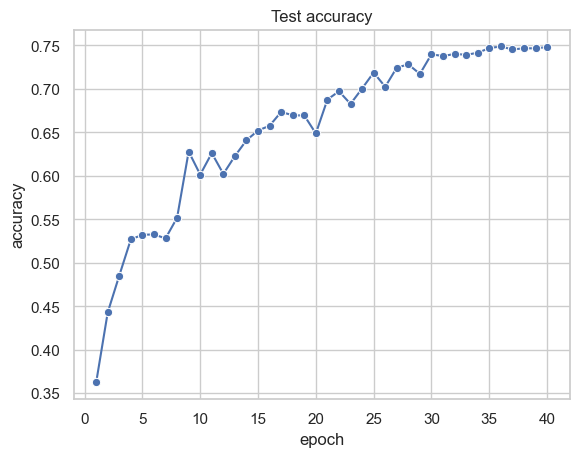

In [ ]:

model = Net2(num_classes=N_CLASSES)  
model, hist = fit(model, dataloader_train, dataloader_test, device, epochs=40, lr=0.001)


df = pd.DataFrame(hist)
sns.set_theme(style="whitegrid")
plt.figure()
sns.lineplot(data=df, x="epoch", y="acc", marker="o")
plt.title("Test accuracy")
plt.ylabel("accuracy")
plt.show()

epoch 01: score 1239/10000  acc=0.1239
epoch 02: score 1563/10000  acc=0.1563
epoch 03: score 2029/10000  acc=0.2029
epoch 04: score 2147/10000  acc=0.2147
epoch 05: score 2509/10000  acc=0.2509
epoch 06: score 2752/10000  acc=0.2752
epoch 07: score 2910/10000  acc=0.2910
epoch 08: score 3166/10000  acc=0.3166
epoch 09: score 3185/10000  acc=0.3185
epoch 10: score 3394/10000  acc=0.3394
epoch 11: score 3496/10000  acc=0.3496
epoch 12: score 3347/10000  acc=0.3347
epoch 13: score 3315/10000  acc=0.3315
epoch 14: score 3300/10000  acc=0.3300
epoch 15: score 3501/10000  acc=0.3501
epoch 16: score 3597/10000  acc=0.3597
epoch 17: score 3697/10000  acc=0.3697
epoch 18: score 3735/10000  acc=0.3735
epoch 19: score 3597/10000  acc=0.3597
epoch 20: score 3801/10000  acc=0.3801
epoch 21: score 3798/10000  acc=0.3798
epoch 22: score 4005/10000  acc=0.4005
epoch 23: score 3956/10000  acc=0.3956
epoch 24: score 4115/10000  acc=0.4115
epoch 25: score 3897/10000  acc=0.3897
epoch 26: score 3954/1000

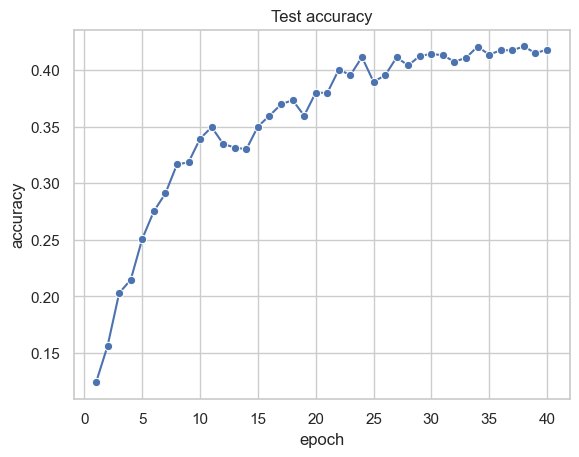

In [44]:
model = Net3(num_classes=N_CLASSES)  
model, hist = fit(model, dataloader_train, dataloader_test, device, epochs=40, lr=0.001)


df = pd.DataFrame(hist)
sns.set_theme(style="whitegrid")
plt.figure()
sns.lineplot(data=df, 
             x="epoch", 
             y="acc", 
             marker="o")
plt.title("Test accuracy")
plt.ylabel("accuracy")
plt.show()

As a result we see that network 2 is the best.
Next step is to upgrade network 2.

In [ ]:
class Net2Plus(nn.Module):
    """Updated second net with one additional convolutional layer"""
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),  # <- here
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.2),                    
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        return self.classifier(self.features(x))


epoch 01: score 4281/10000  acc=0.4281
epoch 02: score 4606/10000  acc=0.4606
epoch 03: score 5308/10000  acc=0.5308
epoch 04: score 5517/10000  acc=0.5517
epoch 05: score 5668/10000  acc=0.5668
epoch 06: score 5978/10000  acc=0.5978
epoch 07: score 6038/10000  acc=0.6038
epoch 08: score 6496/10000  acc=0.6496
epoch 09: score 6720/10000  acc=0.6720
epoch 10: score 6735/10000  acc=0.6735
epoch 11: score 6928/10000  acc=0.6928
epoch 12: score 7072/10000  acc=0.7072
epoch 13: score 7140/10000  acc=0.7140
epoch 14: score 6906/10000  acc=0.6906
epoch 15: score 7153/10000  acc=0.7153
epoch 16: score 7133/10000  acc=0.7133
epoch 17: score 7267/10000  acc=0.7267
epoch 18: score 7380/10000  acc=0.7380
epoch 19: score 7437/10000  acc=0.7437
epoch 20: score 7508/10000  acc=0.7508
epoch 21: score 7281/10000  acc=0.7281
epoch 22: score 7510/10000  acc=0.7510
epoch 23: score 7714/10000  acc=0.7714
epoch 24: score 7473/10000  acc=0.7473
epoch 25: score 7780/10000  acc=0.7780
epoch 26: score 7736/1000

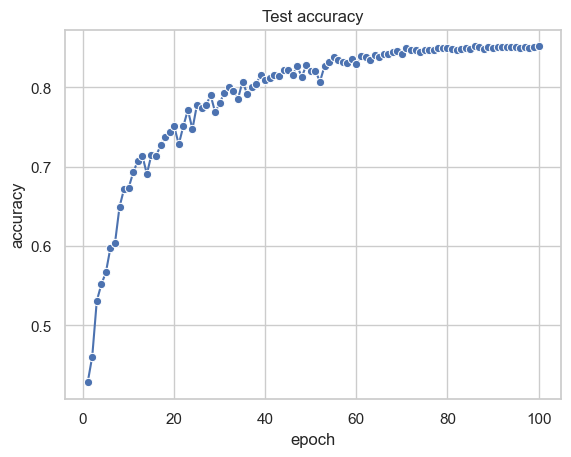

In [42]:

model = Net2Plus(num_classes=N_CLASSES)  
model, hist = fit(model, dataloader_train, dataloader_test, device, epochs=100, lr=0.001)


df = pd.DataFrame(hist)
sns.set_theme(style="whitegrid")
plt.figure()
sns.lineplot(data=df, x="epoch", y="acc", marker="o")
plt.title("Test accuracy")
plt.ylabel("accuracy")
plt.show()

Afterr 100 epochs final score is 85%

In [ ]:
model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1) 
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

epoch 01: score 7120/10000  acc=0.7120
epoch 02: score 7482/10000  acc=0.7482
epoch 03: score 8064/10000  acc=0.8064
epoch 04: score 7964/10000  acc=0.7964
epoch 05: score 8170/10000  acc=0.8170
epoch 06: score 8167/10000  acc=0.8167
epoch 07: score 8210/10000  acc=0.8210
epoch 08: score 8223/10000  acc=0.8223
epoch 09: score 8215/10000  acc=0.8215
epoch 10: score 8310/10000  acc=0.8310
epoch 11: score 8361/10000  acc=0.8361
epoch 12: score 8371/10000  acc=0.8371
epoch 13: score 8217/10000  acc=0.8217
epoch 14: score 8446/10000  acc=0.8446
epoch 15: score 8383/10000  acc=0.8383
epoch 16: score 8359/10000  acc=0.8359
epoch 17: score 8475/10000  acc=0.8475
epoch 18: score 8441/10000  acc=0.8441
epoch 19: score 8418/10000  acc=0.8418
epoch 20: score 8466/10000  acc=0.8466
epoch 21: score 8453/10000  acc=0.8453
epoch 22: score 8448/10000  acc=0.8448
epoch 23: score 8382/10000  acc=0.8382
epoch 24: score 8442/10000  acc=0.8442
epoch 25: score 8473/10000  acc=0.8473
epoch 26: score 8505/1000

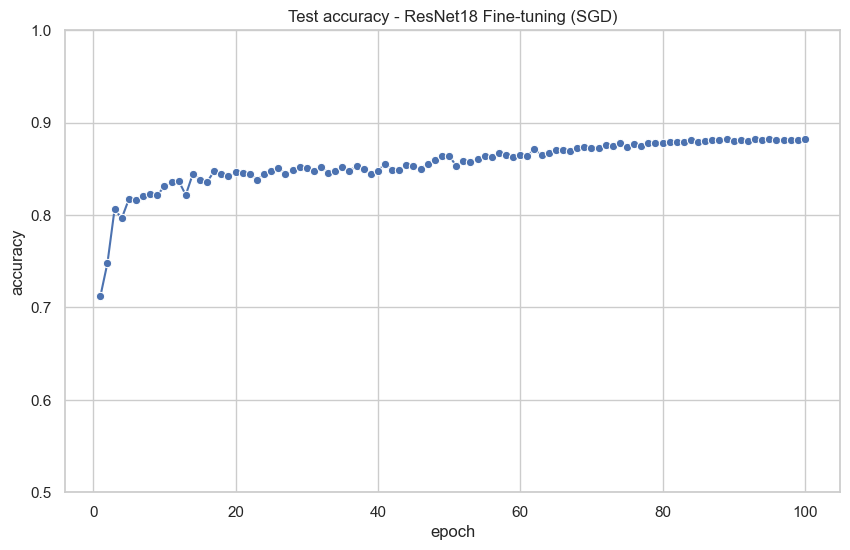

In [ ]:
model, hist = fit(model, dataloader_train, dataloader_test, device, epochs=100, lr=0.01)


df = pd.DataFrame(hist)
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="epoch", y="acc", marker="o")
plt.title("Test accuracy - ResNet18 Fine-tuning (SGD)")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.grid(True)
plt.ylim([0.5, 1.0])
plt.show()